--- Запуск обучения: PPO_Default ---


d:\study\hw rl\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Результат PPO_Default: Mean Reward = -31.34 +/- 17.77


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Видео сохранено: ./rl_videos/PPO_Default.mp4
--- Запуск обучения: A2C_Default ---


d:\study\hw rl\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Результат A2C_Default: Mean Reward = 113.17 +/- 103.07


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Видео сохранено: ./rl_videos/A2C_Default.mp4
--- Запуск обучения: PPO_LargeNet ---
Результат PPO_LargeNet: Mean Reward = -97.26 +/- 47.37


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Видео сохранено: ./rl_videos/PPO_LargeNet.mp4


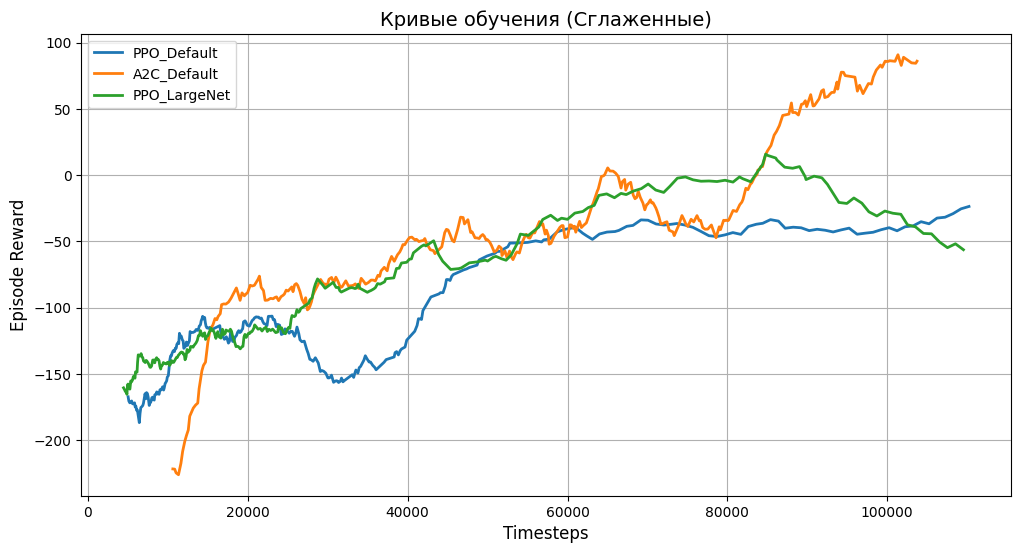


--- Итоговая сводка ---
PPO Default: -31.34
A2C Default: 113.17
PPO LargeNet: -97.26


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import imageio
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os

# 1. Настройки и константы
ENV_ID = "LunarLander-v3"
TOTAL_TIMESTEPS = 100_000  # Достаточно для LunarLander
SEED = 42
LOG_DIR = "./rl_logs/"
VIDEO_DIR = "./rl_videos/"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

# Функция для создания среды с мониторингом (для графиков)
def make_env(env_id, rank, seed=0):
    def _init():
        env = gym.make(env_id, render_mode="rgb_array")
        env = Monitor(env, filename=os.path.join(LOG_DIR, str(rank)))
        env.reset(seed=seed + rank)
        return env
    return _init

# Функция для обучения и возврата логов
def train_agent(algo_class, name, policy_kwargs=None, color='blue'):
    print(f"--- Запуск обучения: {name} ---")
    
    # Создаем среду
    # Используем DummyVecEnv (один процесс), чтобы проще собирать логи Monitor
    env = make_vec_env(ENV_ID, n_envs=1, seed=SEED, monitor_dir=LOG_DIR)
    
    # Инициализация модели
    model = algo_class(
        "MlpPolicy",
        env,
        policy_kwargs=policy_kwargs,
        verbose=0,
        seed=SEED,
        device='auto' # Использует CPU или GPU
    )
    
    # Обучение
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    
    # Сохранение модели (опционально)
    model.save(f"{name}_model")
    
    # Оценка (количественная)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Результат {name}: Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
    
    return model, mean_reward

# Функция для чтения логов Monitor (для графиков)
def get_log_data(log_dir):
    from stable_baselines3.common.results_plotter import load_results, ts2xy
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    return x, y

# Функция для записи видео
def record_video(model, name):
    env = gym.make(ENV_ID, render_mode="rgb_array")
    obs, _ = env.reset(seed=SEED)
    images = []
    
    done = False
    truncated = False
    while not (done or truncated):
        images.append(env.render())
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
    
    env.close()
    
    # Сохранение видео
    video_path = os.path.join(VIDEO_DIR, f"{name}.mp4")
    imageio.mimsave(video_path, images, fps=30)
    print(f"Видео сохранено: {video_path}")

# --- ЭКСПЕРИМЕНТЫ ---

results = {} # Словарь для хранения данных графиков

# 1. Эксперимент: PPO (Baseline)
# Очистим папку логов перед запуском, чтобы не смешивать данные
os.system(f"rm {LOG_DIR}/*.monitor.csv") 
model_ppo, score_ppo = train_agent(PPO, "PPO_Default")
results['PPO_Default'] = get_log_data(LOG_DIR)
record_video(model_ppo, "PPO_Default")

# 2. Эксперимент: A2C (Сравнение алгоритмов)
os.system(f"rm {LOG_DIR}/*.monitor.csv")
model_a2c, score_a2c = train_agent(A2C, "A2C_Default")
results['A2C_Default'] = get_log_data(LOG_DIR)
record_video(model_a2c, "A2C_Default")

# 3. Эксперимент: PPO Large Net (Изменение архитектуры)
# net_arch=[256, 256] означает два скрытых слоя по 256 нейронов
policy_kwargs = dict(net_arch=[256, 256])
os.system(f"rm {LOG_DIR}/*.monitor.csv")
model_ppo_large, score_ppo_large = train_agent(PPO, "PPO_LargeNet", policy_kwargs)
results['PPO_LargeNet'] = get_log_data(LOG_DIR)
record_video(model_ppo_large, "PPO_LargeNet")

# --- ПОСТРОЕНИЕ ГРАФИКОВ ---

def moving_average(values, window):
    """Сглаживание графика"""
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

plt.figure(figsize=(12, 6))

for name, (x, y) in results.items():
    # Сглаживаем данные для красоты (окно 50 эпизодов)
    y_smooth = moving_average(y, 50)
    x_smooth = x[len(x) - len(y_smooth):]
    
    plt.plot(x_smooth, y_smooth, label=name, linewidth=2)

plt.title("Кривые обучения (Сглаженные)", fontsize=14)
plt.xlabel("Timesteps", fontsize=12)
plt.ylabel("Episode Reward", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("training_comparison.png")
plt.show()

# Вывод итоговой таблицы
print("\n--- Итоговая сводка ---")
print(f"PPO Default: {score_ppo:.2f}")
print(f"A2C Default: {score_a2c:.2f}")
print(f"PPO LargeNet: {score_ppo_large:.2f}")